# Internet Traffic classification using passive measurements of TCP connections

### by: Mithra Gholami

##### Dataset link: http://tstat.polito.it/traces-tcpcomplete.shtml 
##### The meaning of each feature: http://tstat.tlc.polito.it/measure.shtml#log_tcp_complete
##### More Info: https://smartdata.polito.it/five-years-at-the-edge-watching-internet-from-the-isp-network/

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import random
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# reading the csv file, using pandas 
data_frame = pd.read_csv("../Desktop/ML_Proj_TCP/log_tcp_complete_classes.txt", sep=" ")

#renaming the last column (labels) for easier usage
data_frame = data_frame.rename(columns={'class:207' : 'class207'}) 

# number of TCP connections in data set
data_frame.shape[0]

100000

In [3]:
# do NOT use IP addresses----> high cardinality leads to overfitting.
# do NOT use information about the server providing the service (e.g., its domain name)----> makes the problem trivial.
# should not be used: #31#c_ip:1, c_port:2, s_ip:15, s_port:16, c_tls_SNI:116, s_tls_SCN:117, fqdn:127
features =  [
            "c_pkts_all:3",
            "s_pkts_all:17",
            "con_t:42",
            'c_rtt_avg:45',
            'c_rtt_min:46',
            'c_rtt_std:48',
            's_rtt_avg:52',
            's_rtt_std:55',
            'c_mss_min:72',
            'c_msgsize_count:131',
            's_msgsize_count:142',
            "c_pkts_data_avg:194",
            'c_pkts_data_std:195',
            "s_pkts_data_avg:197",
            's_pkts_data_std:198',
            'c_seg_cnt:199',
            "c_sit_avg:200",
            's_seg_cnt:202',
            "s_sit_avg:203",
            "c_pkts_push:205",
            "s_pkts_push:206"
]

In [4]:
# Shuffle all the rows
shuffled_data = data_frame.sample(frac=1, random_state=42)
print(shuffled_data.iloc[:10,-1])

75721    class:facebook
80184        class:ebay
19864        class:bing
76699    class:facebook
92991      class:amazon
76434    class:facebook
84004        class:ebay
80917        class:ebay
60767     class:spotify
50074     class:netflix
Name: class207, dtype: object


In [5]:
# tokenizing the labels
shuffled_data['class207'] = pd.Categorical(shuffled_data['class207'])   # labels are now of type categorical
shuffled_data['class207'] = shuffled_data.class207.cat.codes

labels = shuffled_data['class207'] 
print(labels[:10])

75721    3
80184    2
19864    1
76699    3
92991    0
76434    3
84004    2
80917    2
60767    8
50074    7
Name: class207, dtype: int8


In [6]:
# services = ['google', 'bing', 'linkedin', 'instagram', 'youtube', 'netflix', 'spotify', 'facebook', 'ebay', 'amazon']
depth = 10 

# one-hot encoding the labels
oneHotEncoded_labels = tf.one_hot(labels, depth)

In [7]:
# printing the first 5 vectors
oneHotEncoded_labels[:5]

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [8]:
# "data" contains chosen columns by feature name
data = shuffled_data.loc[:,features]
data[0:1]

,c_pkts_all:3,s_pkts_all:17,con_t:42,c_rtt_avg:45,c_rtt_min:46,c_rtt_std:48,s_rtt_avg:52,s_rtt_std:55,c_mss_min:72,c_msgsize_count:131,...,c_pkts_data_avg:194,c_pkts_data_std:195,s_pkts_data_avg:197,s_pkts_data_std:198,c_seg_cnt:199,c_sit_avg:200,s_seg_cnt:202,s_sit_avg:203,c_pkts_push:205,s_pkts_push:206
75721,10,10,8192,3.496413,3.237,0.19828,22.023599,0.606133,51,3,...,589.666667,542.540628,730.25,648.489619,3,19.9995,8,29.230571,3,6


In [9]:
# types of the chosen features
data.dtypes

c_pkts_all:3             int64
s_pkts_all:17            int64
con_t:42                 int64
c_rtt_avg:45           float64
c_rtt_min:46           float64
c_rtt_std:48           float64
s_rtt_avg:52           float64
s_rtt_std:55           float64
c_mss_min:72             int64
c_msgsize_count:131      int64
s_msgsize_count:142      int64
c_pkts_data_avg:194    float64
c_pkts_data_std:195    float64
s_pkts_data_avg:197    float64
s_pkts_data_std:198    float64
c_seg_cnt:199            int64
c_sit_avg:200          float64
s_seg_cnt:202            int64
s_sit_avg:203          float64
c_pkts_push:205          int64
s_pkts_push:206          int64
dtype: object

In [10]:
# train and validation set (75% , 25%)

train_set = data.iloc[:int(0.75*len(shuffled_data)), : ]  # type: DataFrame
train_labels = oneHotEncoded_labels[:int(0.75*len(shuffled_data))]      # type: ndarray

test_set = data.iloc[int(0.75*len(shuffled_data)): , : ]
test_labels = oneHotEncoded_labels[int(0.75*len(shuffled_data)):]

print("number of train set elements:", len(train_set))
print("number of train labels:", len(train_labels))
print("number of test set elements:", len(test_set))
print("number of test labels:", len(test_labels))
print(train_labels[1])

number of train set elements: 75000
number of train labels: 75000
number of test set elements: 25000
number of test labels: 25000
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [11]:
# shapes of data-set and labels
print(train_set.shape,train_labels.shape)
print(test_set.shape,test_labels.shape)

(75000, 21) (75000, 10)
(25000, 21) (25000, 10)


In [12]:
# preparing the trainset and validationset

trainset = tf.data.Dataset.from_tensor_slices((train_set.values , np.array(train_labels))).batch(50)
validationset = tf.data.Dataset.from_tensor_slices((test_set.values , np.array(test_labels))).batch(50)

In [19]:
# train_set.values?
# for feat, targ in trainset.take(5):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [27]:
# model definition

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

##################################
# adjusting the learning rate
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 5))
# optimizer = tf.keras.optimizers.Adam(lr=1e-8)
# # adam.lr.assign(lr=1e-8, momentum=0.9)

# tf.keras.backend.set_floatx('float64')

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['accuracy'])
# history = model.fit(trainset, validation_data = validationset,  epochs=num_epochs, callbacks=[lr_schedule])
##################################



tf.keras.backend.set_floatx('float64')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

In [33]:
# model.summary()

In [28]:
# training the model
num_epochs = 30
history = model.fit(trainset, validation_data = validationset,  epochs=num_epochs)

print("Training Complete")

Epoch 1/30
1500/1500 [==============================] - 20s 13ms/step - loss: 1.3279 - accuracy: 0.5161 - val_loss: 0.9942 - val_accuracy: 0.6523
Epoch 2/30
1500/1500 [==============================] - 20s 13ms/step - loss: 0.8980 - accuracy: 0.6841 - val_loss: 0.8118 - val_accuracy: 0.7092
Epoch 3/30
1500/1500 [==============================] - 19s 13ms/step - loss: 0.7537 - accuracy: 0.7366 - val_loss: 0.7092 - val_accuracy: 0.7551
Epoch 4/30
1500/1500 [==============================] - 19s 13ms/step - loss: 0.6720 - accuracy: 0.7669 - val_loss: 0.6535 - val_accuracy: 0.7730
Epoch 5/30
1500/1500 [==============================] - 19s 13ms/step - loss: 0.6149 - accuracy: 0.7871 - val_loss: 0.6719 - val_accuracy: 0.7644
Epoch 6/30
1500/1500 [==============================] - 20s 13ms/step - loss: 0.5934 - accuracy: 0.7960 - val_loss: 0.5957 - val_accuracy: 0.7956
Epoch 7/30
1500/1500 [==============================] - 20s 13ms/step - loss: 0.5515 - accuracy: 0.8108 - val_loss: 0.5711 -

<Figure size 432x288 with 0 Axes>

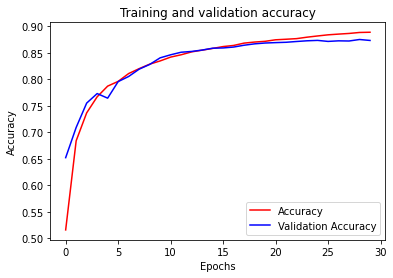

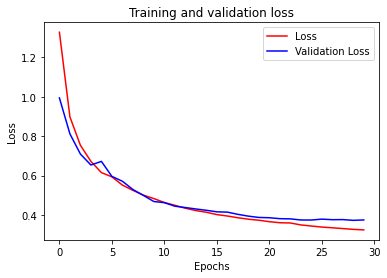

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()